## Evaluation of Generators for future Energy Scenarios


Plot the Power Plants (New and Old)

In [33]:
"""
Setup environment and load the base PyPSA-Earth network for a specified country.
"""
import os
import sys
import warnings
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import pandas as pd
from pathlib import Path
import os
import shutil
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import requests
from matplotlib.colors import LinearSegmentedColormap, to_hex

# Import all dirs
parent_dir = Path(os.getcwd()).parents[0]
sys.path.append(str(parent_dir))
from src.paths import all_dirs
dirs = all_dirs()

# Suppress warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

In [34]:
ppl_path = dirs["data/processed/generation"]
os.makedirs(ppl_path, exist_ok=True)
out_file = os.path.join(ppl_path, "powerplants_all.csv")
all_ppl_file = out_file

CSV_PATH = all_ppl_file
YEAR_START = 2015

# Provided technology translation
tech_translation = {
    "Pasada": "Run-of-river hydro",
    "Embalse": "Reservoir hydro",
    "Eólica": "Wind",
    "Eolica": "Wind",
    "Fotovoltaica": "Solar PV",
    "MCI": "Internal combustion",
    "Turbogás": "Gas turbine",
    "Turbovapor": "Steam turbine",
    "Biomasa": "Biomass",
    "Biogás": "Biogas",
}

# Load
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

df.columns

Index(['Name', 'Fueltype', 'Technology', 'Set', 'Country', 'Capacity',
       'Efficiency', 'Duration', 'Volume_Mm3', 'DamHeight_m',
       'StorageCapacity_MWh', 'DateIn', 'DateRetrofit', 'DateOut', 'lat',
       'lon', 'EIC', 'projectID'],
      dtype='object')

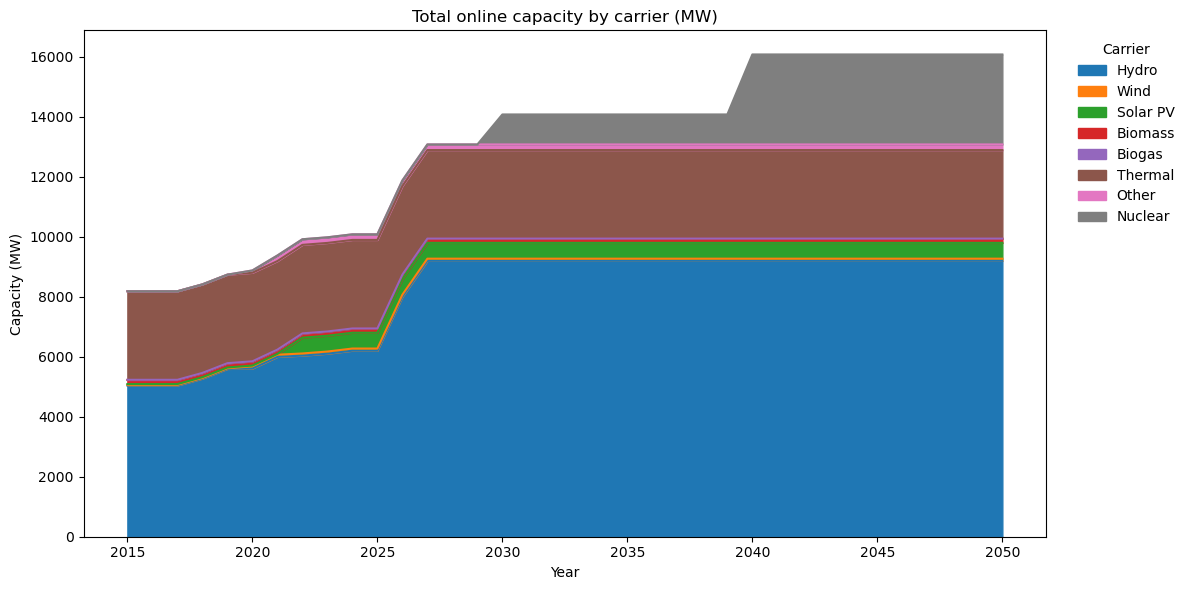

In [35]:

# Normalize fields
for col in ["Fueltype", "Technology"]:
    df[col] = df[col].astype(str).str.strip()

def parse_year(col):
    s = col.astype(str).str.strip()
    # Prefer strict YYYY parsing if the cell is just a year
    y = pd.to_datetime(s, format="%Y", errors="coerce").dt.year
    # Fallback: extract any 4-digit year present (e.g., '2000-05-01' or mixed)
    y_fallback = pd.to_numeric(s.str.extract(r'(\d{4})')[0], errors="coerce")
    return y.fillna(y_fallback)

# Derive carrier using both Fueltype and Technology
def map_carrier(row):
    fuel = row["Fueltype"]
    tech = row["Technology"]
    if fuel == "Hidraulica":
        return "Hydro"
    if fuel in ("Eolica", "Eólica"):
        return "Wind"
    if fuel == "Fotovoltaica":
        return "Solar PV"
    # Biomass/Biogas can be recorded under thermal; prioritize tech names
    if tech == "Biomasa":
        return "Biomass"
    if tech in ("Biogás", "Biogas"):
        return "Biogas"
    if fuel == "Biomasa":
        return "Biomass"
    if fuel in ("Biogás", "Biogas"):
        return "Biogas"
    if fuel == "Termica" and tech not in ("Biomasa", "Biogás", "Biogas"):
        return "Thermal"
    if fuel == "Nuclear":
        return "Nuclear"
    # Fallbacks via tech translation (optional)
    t = tech_translation.get(tech)
    if t in ("Run-of-river hydro", "Reservoir hydro"):
        return "Hydro"
    if t == "Wind":
        return "Wind"
    if t == "Solar PV":
        return "Solar PV"
    if t == "Nuclear":
        return "Nuclear"
    return "Other"

df["Capacity"] = pd.to_numeric(df["Capacity"], errors="coerce")
df["year_in"] = parse_year(df["DateIn"])
df["year_out"] = parse_year(df["DateOut"])

df = df.dropna(subset=["Capacity", "year_in"])


df["carrier"] = df.apply(map_carrier, axis=1)


# Build year range and cumulative online capacity per year
max_year = int(max(df["year_in"].max(), pd.Series([YEAR_START]).max(),
                   pd.Series([2050]).max()))
if df["year_out"].notna().any():
    max_year = int(max(max_year, df["year_out"].max()))
years = range(YEAR_START, max_year + 1)

carriers = sorted(df["carrier"].unique(), key=lambda c: {
    "Hydro": 0, "Wind": 1, "Solar PV": 2, "Biomass": 3, "Biogas": 4, "Thermal": 5, 
    "Nuclear": 6, "Other": 6
}.get(c, 99))

# Initialize frame: rows=years, cols=carriers
cap_year = pd.DataFrame(0.0, index=years, columns=carriers)

# Add capacity for each plant to all years it is online [in, out]
for _, r in df.iterrows():
    y0 = max(int(r["year_in"]), YEAR_START)
    y1 = int(r["year_out"]) if pd.notna(r["year_out"]) else max_year
    if y1 < YEAR_START:
        continue
    cap_year.loc[y0:y1, r["carrier"]] += float(r["Capacity"])

# Plot stacked area
ax = cap_year[carriers].plot.area(figsize=(12, 6))
ax.set_title("Total online capacity by carrier (MW)")
ax.set_xlabel("Year")
ax.set_ylabel("Capacity (MW)")
ax.legend(title="Carrier", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()

# Save figure
plt.savefig(
    os.path.join(dirs["results/graphs"], "ecuador_installed_cap.png"),
    dpi=600,
)

plt.show()


Plot Ecuadorian power plants by technology and capacity (English labels).


In [36]:
"""
Multi-map plotting of Ecuadorian power plants:
- Three cases: All, DateIn<2017, DateIn>=2017
- For each case: (A) Ecuador incl. Galápagos, (B) Continental Ecuador only (manual bbox)
- Saves 6 PNG files total.

Requires df with columns:
['Name','Fueltype','Technology','Capacity','lat','lon','DateIn']
"""

import os
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
import requests

# ===================== CONFIG =====================
COUNTRY_ISO3 = "ECU"
YEAR_SPLIT = 2017
OUTDIR = dirs["results/graphs"]  # change if desired
Path(OUTDIR).mkdir(parents=True, exist_ok=True)

# Where to put / find GADM (expects dirs["data/raw/gadm"])
GADM_BASE_DIR = None  # will be inferred from dirs dict below
GADM_VERSION = "4.1"
GADM_FILE_STEM = f"gadm41_{COUNTRY_ISO3}"
GADM_LAYER_L1 = "ADM_ADM_1"
GADM_URL = f"https://geodata.ucdavis.edu/gadm/gadm{GADM_VERSION}/gpkg/{GADM_FILE_STEM}.gpkg"

# --- Manual continental Ecuador bounding box (EPSG:4326) ---
# (xmin, ymin, xmax, ymax)
CONTINENTAL_BBOX = (-81.2, -5.2, -75.0, 1.8)

# Technology translation (Spanish -> English)
TECH_TRANSLATION = {
    "Hidraulica": "Hydropower",
    "Termica": "Thermal",
    "Fotovoltaica": "Solar PV",
    "Eolica": "Wind",
    "Biomasa": "Biomass",
    "Biogas": "Biogas",
    "Hidroelectrico": "Hydroelectric",
    "Termoelectrico": "Thermoelectric",
    "Eolico": "Wind",
    "ERNC": "Non-Conv. Renew.",
    "Nuclear": "Nuclear",
}

# ===================== UTILITIES =====================
def ensure_gadm_file(gadm_path: str) -> str:
    """Ensure GADM gpkg exists locally; download if missing. Return path to gpkg."""
    gpkg_path = os.path.join(gadm_path, f"{GADM_FILE_STEM}.gpkg")
    gpkg_dir = Path(gpkg_path).parent
    if not Path(gpkg_path).is_file():
        gpkg_dir.mkdir(parents=True, exist_ok=True)
        resp = requests.get(GADM_URL, stream=True, timeout=300)
        resp.raise_for_status()
        with open(gpkg_path, "wb") as f:
            shutil.copyfileobj(resp.raw, f)
    else:
        print(f"GADM file already exists: {gpkg_path}")
    assert Path(gpkg_path).is_file(), f"GADM file not found or failed to download: {gpkg_path}"
    return gpkg_path


def load_shapes(gpkg_path: str) -> gpd.GeoDataFrame:
    """Load L1 admin boundaries for Ecuador (incl. Galápagos)."""
    return gpd.read_file(gpkg_path, layer=GADM_LAYER_L1)


def continental_polygon() -> Polygon:
    xmin, ymin, xmax, ymax = CONTINENTAL_BBOX
    return Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])


def clip_to_continental(boundaries: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Clip GADM boundaries to the manual continental bbox polygon."""
    poly_gdf = gpd.GeoDataFrame(geometry=[continental_polygon()], crs="EPSG:4326")
    if boundaries.crs != "EPSG:4326":
        boundaries = boundaries.to_crs("EPSG:4326")
    try:
        return gpd.overlay(boundaries, poly_gdf, how="intersection")
    except Exception:
        # Fallback: spatial index–free manual clip
        return boundaries.clip(poly_gdf)


def translate_and_prepare(df: pd.DataFrame) -> pd.DataFrame:
    """Clean rows, translate technologies, compute bubble sizes."""
    plot_df = df.dropna(subset=["lat", "lon", "Capacity"]).copy()
    plot_df = plot_df[plot_df["Capacity"].astype(float) > 0]
    plot_df["Technology_Eng"] = (
        plot_df["Fueltype"].map(TECH_TRANSLATION).fillna(plot_df["Technology"])
    )
    cap = plot_df["Capacity"].astype(float)
    plot_df["size"] = np.log10(cap + 1) * 40.0
    return plot_df


def build_color_map(technologies: list[str]):
    n_colors = len(technologies)
    cmap = get_cmap("tab10") if n_colors <= 10 else get_cmap("tab20")
    return {tech: cmap(i / max(n_colors, 1)) for i, tech in enumerate(technologies)}


def df_to_geodf_points(df: pd.DataFrame, crs_epsg: int = 4326) -> gpd.GeoDataFrame:
    """Convert a DataFrame with lon/lat columns to a GeoDataFrame of points."""
    g = gpd.GeoDataFrame(
        df.copy(),
        geometry=[Point(float(x), float(y)) for x, y in zip(df["lon"], df["lat"])],
        crs=f"EPSG:{crs_epsg}",
    )
    return g


def filter_points_continental(gdf_points: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Filter points strictly within the manual continental bbox polygon."""
    poly = continental_polygon()
    if gdf_points.crs != "EPSG:4326":
        gdf_points = gdf_points.to_crs("EPSG:4326")
    return gdf_points[gdf_points.geometry.within(poly)].copy()


def plot_case(
    gdf_points: gpd.GeoDataFrame,
    boundaries: gpd.GeoDataFrame | None,
    title: str,
    outpath: str,
    color_map: dict,
    bbox: tuple | None = None,       # (xmin, ymin, xmax, ymax) to constrain map
    draw_bbox: bool = False,         # draw the bbox rectangle on the map
):
    """Scatter plot by Technology_Eng; optionally clip extent to bbox; save to file."""
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_title(title, fontsize=14)

    # Draw boundaries (if given)
    if boundaries is not None and not boundaries.empty:
        boundaries.boundary.plot(ax=ax, linewidth=0.4, color="black", alpha=0.7)

    # Plot points grouped by technology
    for tech, group in gdf_points.groupby("Technology_Eng"):
        ax.scatter(
            group["lon"].astype(float),
            group["lat"].astype(float),
            s=group["size"],
            color=color_map.get(tech, "gray"),
            label=tech,
            alpha=0.7,
            transform=ccrs.PlateCarree(),
            edgecolors="black",
            linewidth=0.3,
        )

    # Legend
    ax.legend(
        title="Technology Type",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
        borderaxespad=0,
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Set extent
    if bbox is not None:
        xmin, ymin, xmax, ymax = bbox
        pad_x, pad_y = 0.25, 0.25
        ax.set_extent([xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y], crs=ccrs.PlateCarree())
        if draw_bbox:
            ax.plot(
                [xmin, xmax, xmax, xmin, xmin],
                [ymin, ymin, ymax, ymax, ymin],
                transform=ccrs.PlateCarree(),
                linewidth=0.6,
                color="black",
                alpha=0.6,
            )
    elif boundaries is not None and not boundaries.empty:
        xmin, ymin, xmax, ymax = boundaries.total_bounds
        ax.set_extent([xmin - 0.5, xmax + 0.5, ymin - 0.5, ymax + 0.5], crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.savefig(outpath, dpi=600, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    
    



GADM file already exists: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\raw\gadm\gadm41_ECU.gpkg


C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_7928\2207162167.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10") if n_colors <= 10 else get_cmap("tab20")


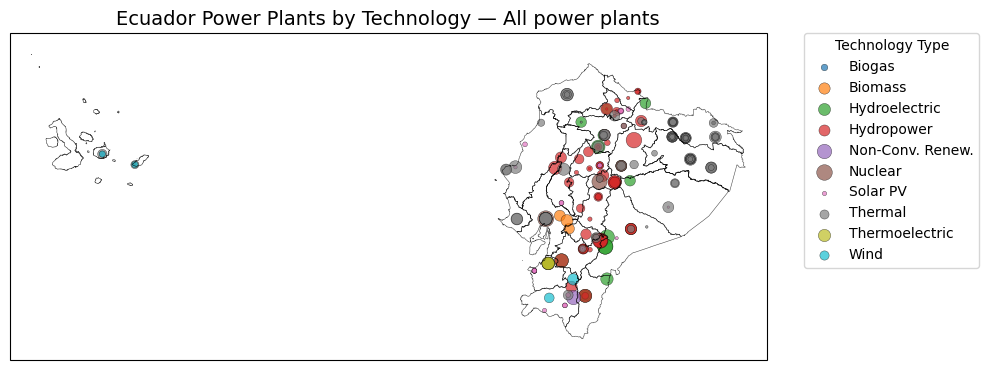

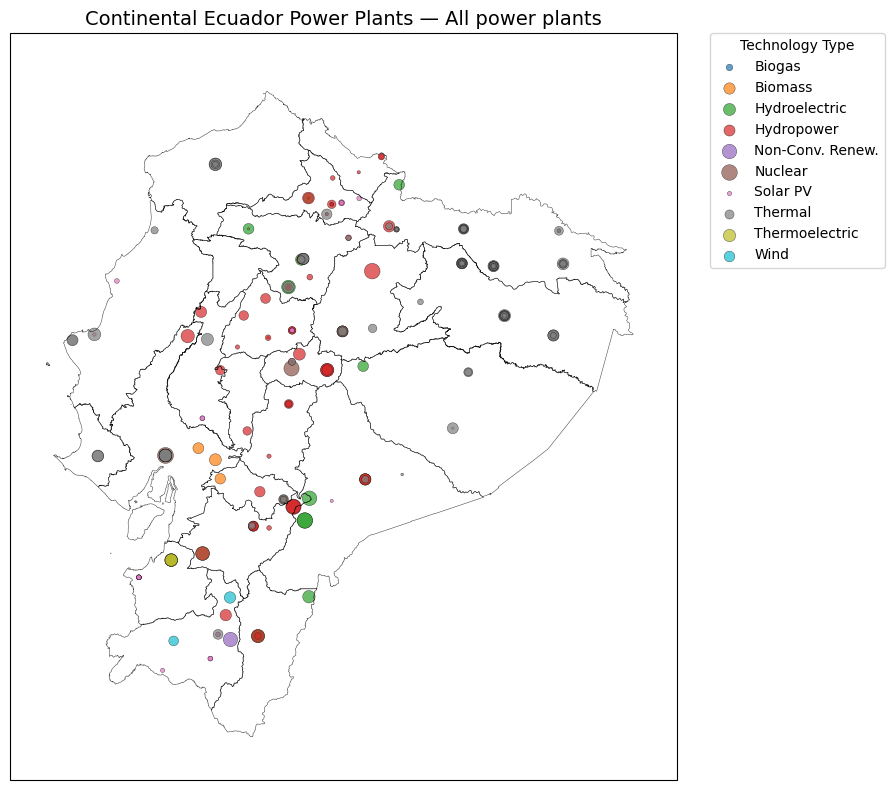

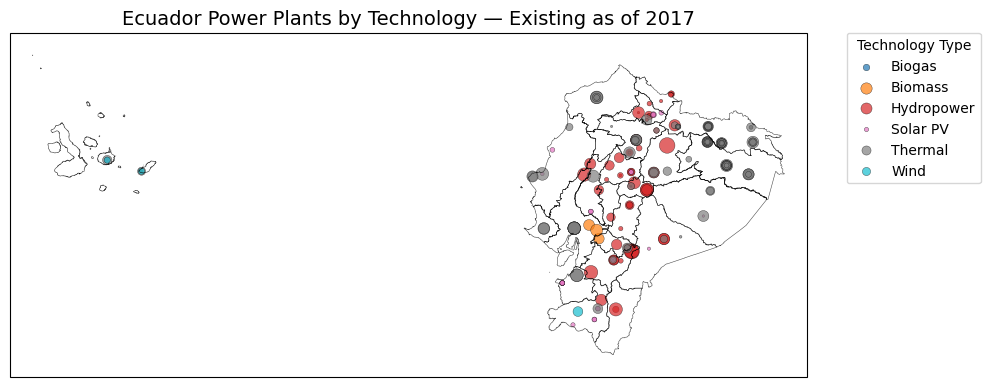

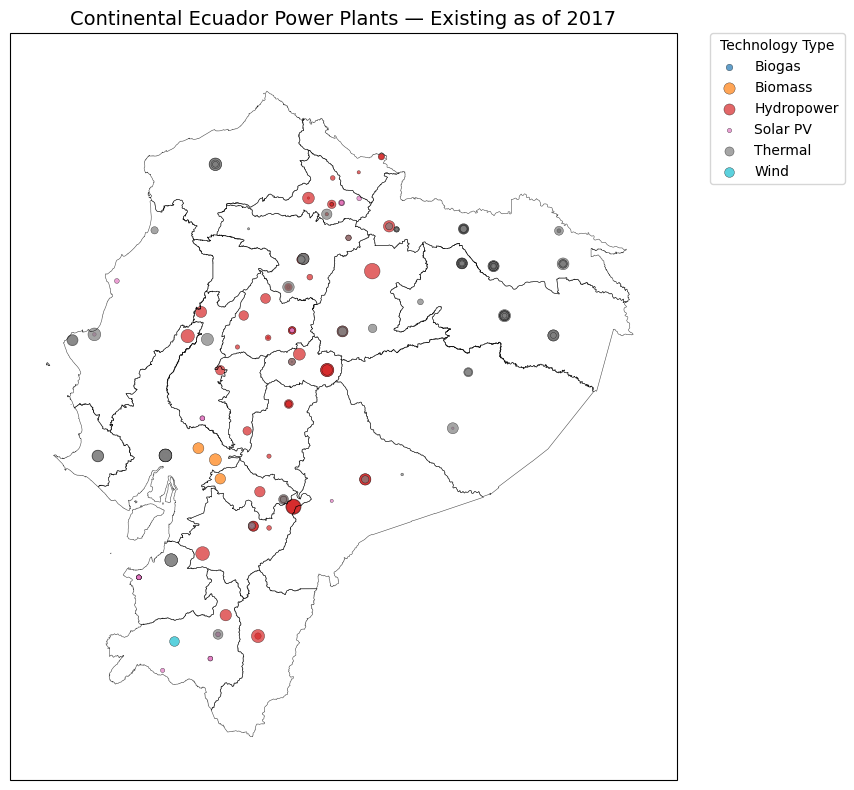

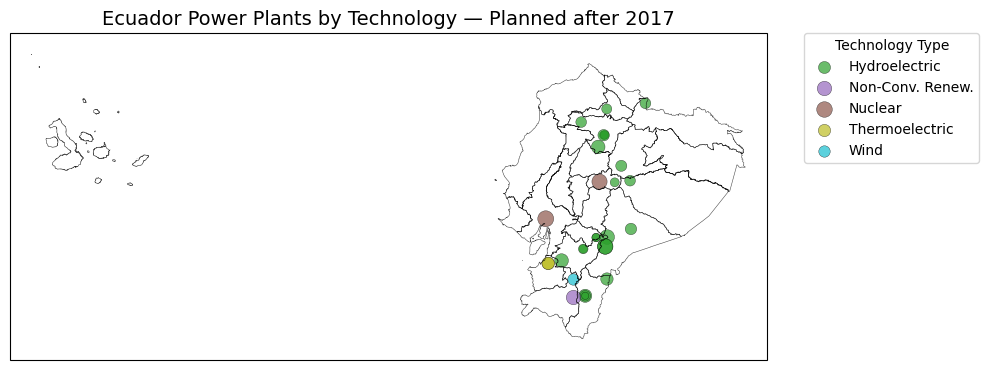

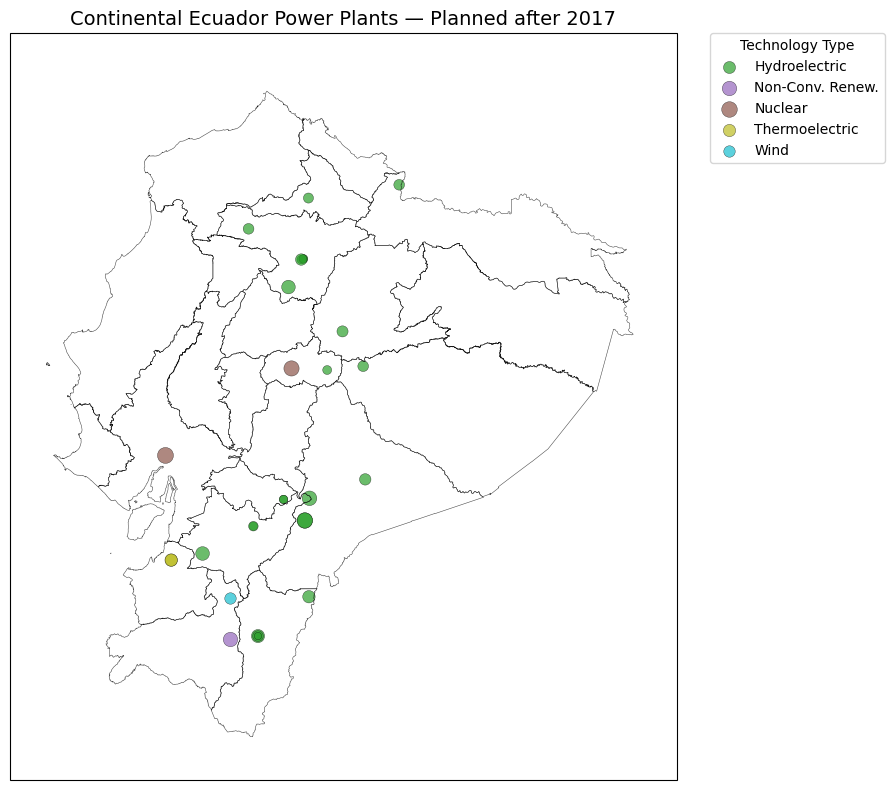

✅ Done. Plots saved in: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\results\graphs


In [37]:

# ===================== MAIN FLOW =====================
# 0) Infer GADM path
GADM_BASE_DIR = dirs["data/raw/gadm"]

# 1) Ensure GADM present and load shapes
gpkg = ensure_gadm_file(GADM_BASE_DIR)
ecuador_shape_all = load_shapes(gpkg)
ecuador_shape_cont = clip_to_continental(ecuador_shape_all)  # outlines clipped to manual bbox

# 2) Prepare data & tech colors
plot_df_all = translate_and_prepare(df)
technologies = sorted(plot_df_all["Technology_Eng"].dropna().unique().tolist())
tech_to_color = build_color_map(technologies)

# GeoDataFrame of points
gdf_all = df_to_geodf_points(plot_df_all, 4326)

# 3) Build three cases
def safe_to_year(x):
    # Accept datetime, int, float, str
    try:
        if pd.api.types.is_integer(x) or (isinstance(x, float) and float(x).is_integer()):
            return int(x)
        dt = pd.to_datetime(x, errors="coerce")
        if pd.notna(dt):
            return int(dt.year)
        return int(x)
    except Exception:
        return np.nan

date_year = df["DateIn"].apply(safe_to_year)
gdf_all["DateInYear"] = date_year.values

cases = [
    ("All power plants", gdf_all.copy(), "all"),
    (f"Existing as of {YEAR_SPLIT}", gdf_all[gdf_all["DateInYear"] < YEAR_SPLIT].copy(), "pre2017"),
    (f"Planned after {YEAR_SPLIT}", gdf_all[gdf_all["DateInYear"] >= YEAR_SPLIT].copy(), "post2017"),
]

# 4) Plot each case: (A) Ecuador incl. Galápagos, (B) Continental only via manual bbox
for title, gdf_case, tag in cases:
    if gdf_case.empty:
        print(f"[INFO] No points for case: {title}. Skipping.")
        continue

    # (A) Ecuador incl. Galápagos
    out_a = os.path.join(OUTDIR, f"ecuador_powerplants_{tag}_all.png")
    plot_case(
        gdf_points=gdf_case,
        boundaries=ecuador_shape_all,
        title=f"Ecuador Power Plants by Technology — {title}",
        outpath=out_a,
        color_map=tech_to_color,
        bbox=None,            # full country
        draw_bbox=False,
    )

    # (B) Continental Ecuador only (manual bbox)
    gdf_mainland = filter_points_continental(gdf_case)
    out_b = os.path.join(OUTDIR, f"ecuador_powerplants_{tag}_continental.png")
    plot_case(
        gdf_points=gdf_mainland,
        boundaries=ecuador_shape_cont,                 # clipped outlines for context
        title=f"Continental Ecuador Power Plants — {title}",
        outpath=out_b,
        color_map=tech_to_color,
        bbox=CONTINENTAL_BBOX,                         # enforce manual extent
        draw_bbox=False,                               # set True if you want the rectangle drawn
    )

print(f"✅ Done. Plots saved in: {OUTDIR}")
